In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay

from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

import wandb
from wandb.keras import WandbCallback

from utils.roc_curve import *
from utils.process_functions import *
from utils.gradient_reversal import GradientReversal

2023-05-29 06:16:32.831609: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Prepare predictions and test data

In [2]:
y_pred_target_km = np.load("./pred/y_pred_target_km.npy")
y_pred_protected_km = np.load("./pred/y_pred_protected_km.npy")

path_test_filenames_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_filenames.npy'
path_test_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_labels.npy'
path_test_cl_labels_array_km = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_cl_labels.npy'
path_test_cl_labels_array_gm = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_cl_labels_gm.npy'

test_filenames_array = np.load(path_test_filenames_array)
test_labels_array = np.load(path_test_labels_array)
test_cl_labels_array_km = np.load(path_test_cl_labels_array_km)
test_cl_labels_array_gm = np.load(path_test_cl_labels_array_gm)

test_filenames = test_filenames_array.tolist()
test_labels_target = tf.keras.utils.to_categorical(test_labels_array.tolist(), num_classes=2,dtype=int)
test_labels_protected_km = tf.keras.utils.to_categorical(test_cl_labels_array_km.tolist(), num_classes=10,dtype=int)
test_labels_protected_gm = tf.keras.utils.to_categorical(test_cl_labels_array_gm.tolist(), num_classes=10,dtype=int)
   
test_data_gen_km = tf.data.Dataset.from_generator(
    lambda: data_generator(test_filenames, test_labels_target, test_labels_protected_km),
    output_types=(tf.string, {'target_branch': tf.int32, 'protected_branch': tf.int32}),
    output_shapes=((), {'target_branch': (2,), 'protected_branch': (10,)}))

test_data_map_km = test_data_gen_km.map(lambda x, y: (process_img(x), y))
test_data_batch_km = test_data_map_km.batch(128)
X_test_km = test_data_batch_km.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

2023-05-29 06:16:52.152261: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-29 06:16:52.153354: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-29 06:16:52.188848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 06:16:52.189040: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2023-05-29 06:16:52.189070: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-29 06:16:52.193496: I tensorflow/stream_executor/platform/def

## Results fair models

### Results from clustering with k-means

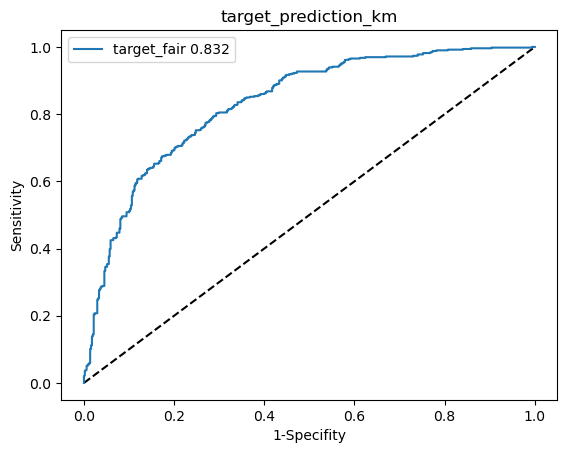

In [3]:
get_roc("target_prediction_km", "./fig/target_fair_km.png", y_pred_target_km[:,1], test_labels_target[:,1], "target_fair")

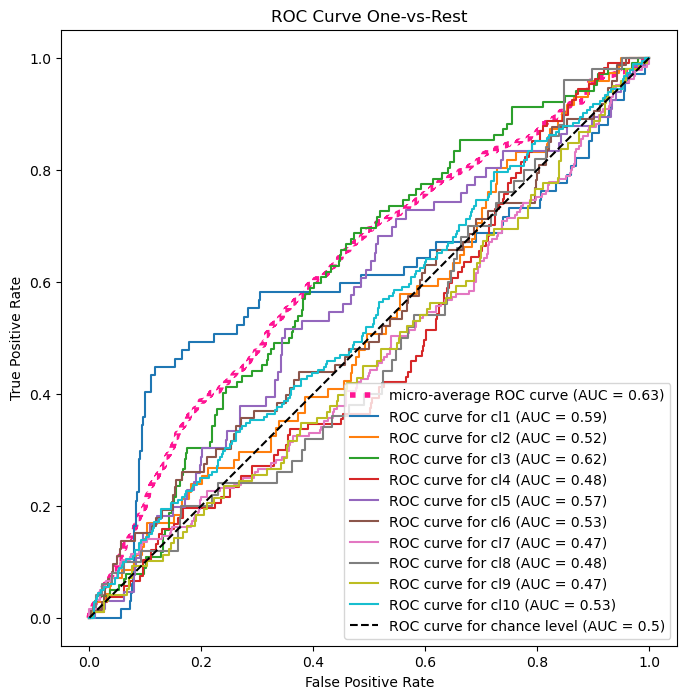

In [4]:
target_names = ["cl1","cl2","cl3","cl4","cl5","cl6","cl7","cl8","cl9","cl10"]
get_roc_multiclass(test_labels_protected_km, y_pred_protected_km, target_names, "./fig/protected_fair_km.png")

### Results from clustering with Gaussian mixture models

In [4]:
y_pred_target_gm = np.load("./pred/y_pred_target_gm.npy")
y_pred_protected_gm = np.load("./pred/y_pred_protected_gm.npy")

path_test_cl_labels_array_gm = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_cl_labels_gm.npy'
test_cl_labels_array_gm = np.load(path_test_cl_labels_array_gm)
test_labels_protected_gm = tf.keras.utils.to_categorical(test_cl_labels_array_gm.tolist(), num_classes=10,dtype=int)
        
test_data_gen_gm = tf.data.Dataset.from_generator(
    lambda: data_generator(test_filenames, test_labels_target, test_labels_protected_gm),
    output_types=(tf.string, {'target_branch': tf.int32, 'protected_branch': tf.int32}),
    output_shapes=((), {'target_branch': (2,), 'protected_branch': (10,)}))

test_data_map_gm = test_data_gen_gm.map(lambda x, y: (process_img(x), y))
test_data_batch_gm = test_data_map_gm.batch(128)
X_test_gm = test_data_batch_gm.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

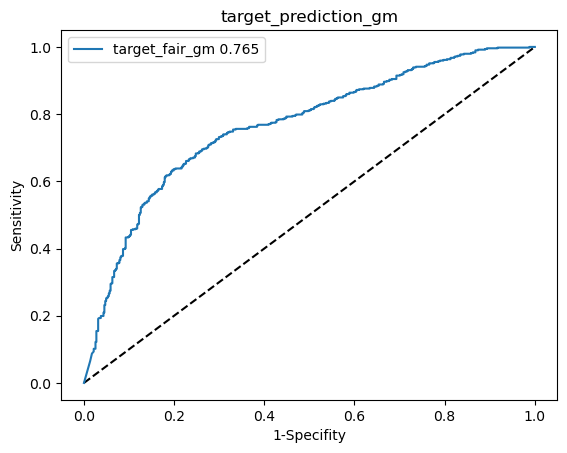

In [5]:
get_roc("target_prediction_gm", "./fig/target_fair_gm.png", y_pred_target_gm[:,1], test_labels_target[:,1], "target_fair_gm")

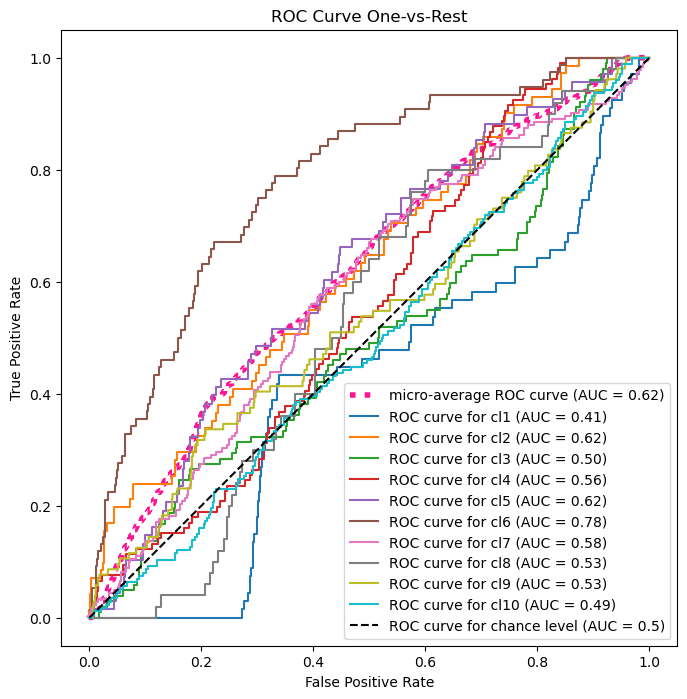

In [6]:
target_names = ["cl1","cl2","cl3","cl4","cl5","cl6","cl7","cl8","cl9","cl10"]
get_roc_multiclass(test_labels_protected_gm, y_pred_protected_gm, target_names, "./fig/protected_fair_gm.png")

## Results baseline model

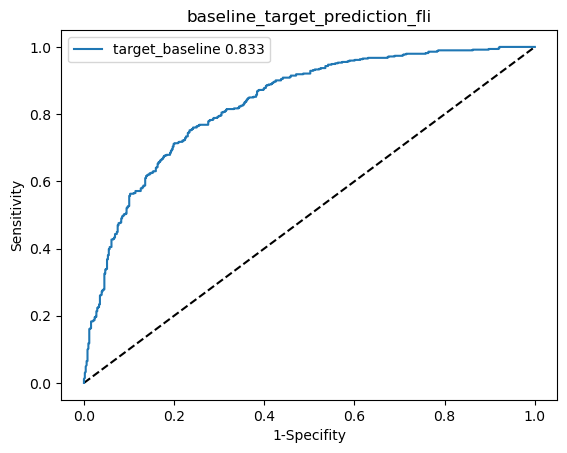

In [4]:
y_pred_target_baseline = np.load("y_pred_target_fli_baseline.npy")
get_roc("baseline_target_prediction_fli", "./fig/baseline_target_fair_fli.png", y_pred_target_baseline, test_labels_target[:,1], "target_baseline")

### Predict clusters from fair model

In [12]:
path_train_filenames_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_filenames.npy'
path_train_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_labels.npy'
path_train_cl_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_cl_labels.npy'

path_val_filenames_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_val_filenames.npy'
path_val_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_val_labels.npy'
path_val_cl_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_val_cl_labels.npy'

path_test_filenames_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_filenames.npy'
path_test_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_labels.npy'
path_test_cl_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_cl_labels.npy'

# Load Data
train_filenames_array = np.load(path_train_filenames_array)
train_cl_labels_array = np.load(path_train_cl_labels_array)

val_filenames_array = np.load(path_val_filenames_array)
val_cl_labels_array = np.load(path_val_cl_labels_array)

test_filenames_array = np.load(path_test_filenames_array)
test_cl_labels_array = np.load(path_test_cl_labels_array)

train_filenames = train_filenames_array.tolist()
train_labels_protected = tf.keras.utils.to_categorical(train_cl_labels_array.tolist(), num_classes=10)

val_filenames = val_filenames_array.tolist()
val_labels_protected = tf.keras.utils.to_categorical(val_cl_labels_array.tolist(), num_classes=10)

test_filenames = test_filenames_array.tolist()
test_labels_protected = tf.keras.utils.to_categorical(test_cl_labels_array.tolist(), num_classes=10,dtype=int)

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels_protected)))
train_data = train_data.map(process_img_label)
train_data = train_data.batch(128)
X_train_protected = train_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels_protected)))
val_data = val_data.map(process_img_label)
val_data = val_data.batch(128)
X_val_protected = val_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices((tf.constant(test_filenames), tf.constant(test_labels_protected)))
test_data = test_data.map(process_img_label)
test_data = test_data.batch(128)
X_test_protected = test_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [13]:
baseline_model_path = './models/baseline_model_fli_pix.h5'
baseline_model = tf.keras.models.load_model(baseline_model_path)

#remove last layer
baseline_wout_last_layer = tf.keras.Sequential(baseline_model.layers[0:2])

# Freeze the layers
for layer in baseline_wout_last_layer.layers:
    layer.trainable = False

# Add a new layer with binary classification output
baseline_wout_last_layer.add(tf.keras.layers.Dense(10, activation='softmax'))

baseline_wout_last_layer.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor (Sequentia (None, 128)               22074792  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 22,076,082
Trainable params: 1,290
Non-trainable params: 22,074,792
_________________________________________________________________


In [14]:
# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
baseline_wout_last_layer.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy','AUC'])

#fit the model
hist = baseline_wout_last_layer.fit(
    X_train_protected, 
    epochs = 10,
    validation_data = X_val_protected, 
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20),
    ]
)
baseline_wout_last_layer.save('./models/baseline_model_fli_cl_pred.h5')

y_pred_protected = baseline_wout_last_layer.predict(X_test_protected)
np.save("./pred/y_pred_protected_fli_baseline.npy",y_pred_protected)

Epoch 1/10
91/91 [==============================] - 24s 244ms/step - loss: 0.7800 - accuracy: 0.1279 - auc: 0.5204 - val_loss: 0.6385 - val_accuracy: 0.1269 - val_auc: 0.5263
Epoch 2/10
91/91 [==============================] - 21s 233ms/step - loss: 0.6054 - accuracy: 0.1283 - auc: 0.5249 - val_loss: 0.5170 - val_accuracy: 0.1277 - val_auc: 0.5344
Epoch 3/10
91/91 [==============================] - 21s 235ms/step - loss: 0.4968 - accuracy: 0.1297 - auc: 0.5358 - val_loss: 0.4428 - val_accuracy: 0.1285 - val_auc: 0.5481
Epoch 4/10
91/91 [==============================] - 21s 233ms/step - loss: 0.4304 - accuracy: 0.1332 - auc: 0.5509 - val_loss: 0.3981 - val_accuracy: 0.1331 - val_auc: 0.5635
Epoch 5/10
91/91 [==============================] - 21s 231ms/step - loss: 0.3904 - accuracy: 0.1392 - auc: 0.5678 - val_loss: 0.3712 - val_accuracy: 0.1409 - val_auc: 0.5797
Epoch 6/10
91/91 [==============================] - 21s 233ms/step - loss: 0.3660 - accuracy: 0.1466 - auc: 0.5858 - val_loss

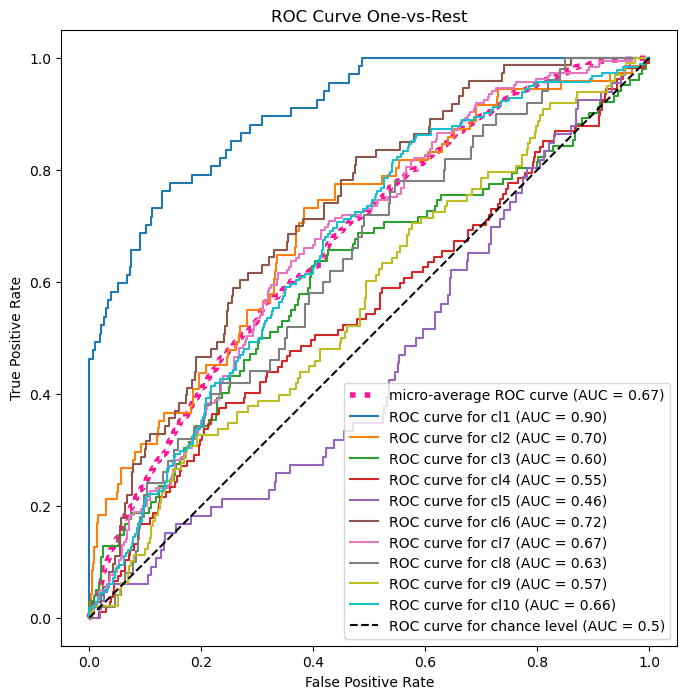

In [23]:
target_names = ["cl1","cl2","cl3","cl4","cl5","cl6","cl7","cl8","cl9","cl10"]
get_roc_multiclass(test_labels_protected, y_pred_protected, target_names, "./fig/protected_fli_baseline.png")

### Test on pixabay data

In [7]:
#Set filepaths pixabay
path_test_filenames_array_pix = '/nasdata/abdu/Learning2Rank/Pixabay/data/top_test_filenames.npy'
path_test_labels_array_pix = '/nasdata/abdu/Learning2Rank/Pixabay/data/top_test_labels.npy'

#Load data pixaby
test_filenames_array_pix = np.load(path_test_filenames_array_pix)
test_labels_array_pix = np.load(path_test_labels_array_pix)

#assert matching shapes
assert (test_filenames_array_pix.shape == test_labels_array_pix.shape)

#data to list
test_filenames_pix = test_filenames_array_pix.tolist()
test_labels_pix = test_labels_array_pix.tolist()

test_data = tf.data.Dataset.from_tensor_slices((tf.constant(test_filenames_pix), tf.constant(test_labels_pix)))
test_data = test_data.map(process_img_label)
test_data = test_data.batch(128)
X_test_pix = test_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [8]:
baseline_model = tf.keras.models.load_model('./models/baseline_model_fli.h5')
y_pred_pix_base = baseline_model.predict(X_test_pix)

2023-05-25 06:24:05.305134: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-25 06:24:05.323587: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3399905000 Hz
2023-05-25 06:24:05.869552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:24:05.880484: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-25 06:24:07.038849: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-05-25 06:24:07.963443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:24:08.031749: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-05-25 06:24:08.091262: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Inter

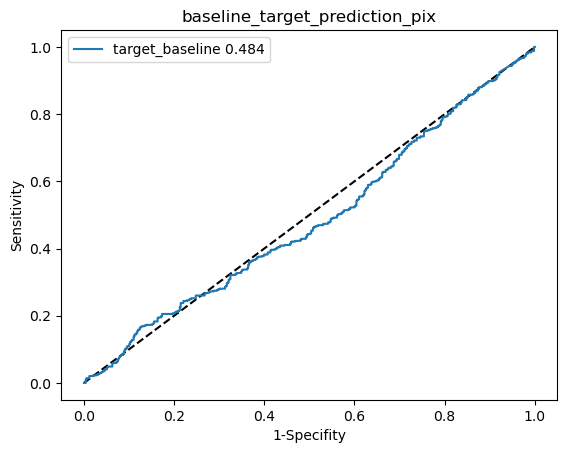

In [15]:
get_roc("baseline_target_prediction_pix", "./fig/baseline_target_fair_pix.png", y_pred_pix_base, test_labels_target[:,1], "target_baseline")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor (Sequentia (None, 128)               22074792  
_________________________________________________________________
target_branch (Sequential)   (None, 2)                 258       
Total params: 22,075,050
Trainable params: 1,213,570
Non-trainable params: 20,861,480
_________________________________________________________________


2023-05-25 06:26:10.463046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:12.361217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:12.823576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:13.033984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:13.861916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:13.950334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:15.168418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:15.663757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:17.059578: W tensorflow/core/lib/png/png_io.cc:88] PNG 

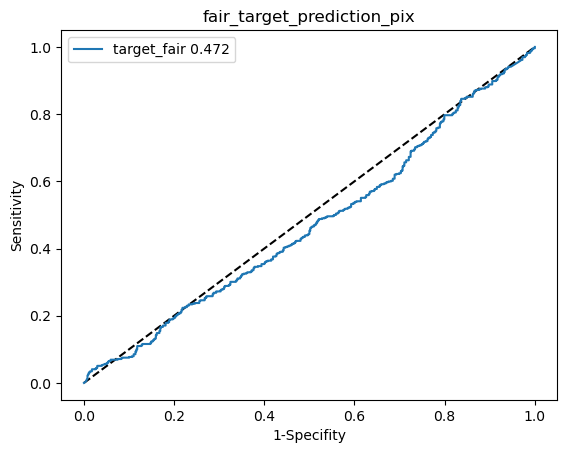

In [12]:
# Load the km model with custom layer
fair_model_km = tf.keras.models.load_model('./models/fair_model_km.h5', custom_objects={'GradientReversal': GradientReversal})
fair_model_reduced_km = tf.keras.Sequential(fair_model_km.layers[0:3])
fair_model_reduced_km.summary()
y_pred_pix_fair_km = fair_model_reduced_km.predict(X_test_pix)

get_roc("fair_target_prediction_pix", "./fig/fair_target_fair_pix.png", y_pred_pix_fair_km[:,1], test_labels_target[:,1], "target_fair")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor (Sequentia (None, 128)               22074792  
_________________________________________________________________
target_branch (Sequential)   (None, 2)                 258       
Total params: 22,075,050
Trainable params: 1,213,570
Non-trainable params: 20,861,480
_________________________________________________________________


2023-05-25 06:26:31.452398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:33.413494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:33.930056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:34.140729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:35.002002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:35.091376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:36.277124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:36.779895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-25 06:26:38.136759: W tensorflow/core/lib/png/png_io.cc:88] PNG 

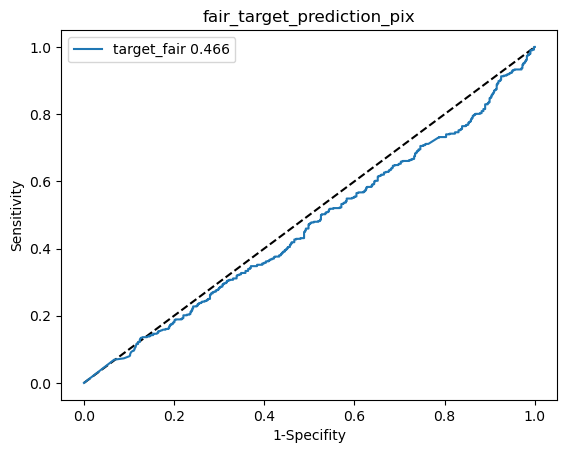

In [13]:
# Load the gm model with custom layer 
fair_model_gm = tf.keras.models.load_model('./models/fair_model_gm.h5', custom_objects={'GradientReversal': GradientReversal})
fair_model_reduced_gm = tf.keras.Sequential(fair_model_gm.layers[0:3])
fair_model_reduced_gm.summary()
y_pred_pix_fair_gm = fair_model_reduced_gm.predict(X_test_pix)

get_roc("fair_target_prediction_pix", "./fig/fair_target_fair_pix.png", y_pred_pix_fair_gm[:,1], test_labels_target[:,1], "target_fair")